# Imports and Setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, Bloch, Bloch3d, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, sigmam, sigmap, tensor, thermal_dm, sesolve, spre, spost, sprepost, to_super)
from qutip.qip.operations import hadamard_transform as HD, rx, ry, rz
from qutip.ipynbtools import plot_animation
from scipy.optimize import curve_fit
from scipy.stats import linregress
# %matplotlib widget
plt.rc('font', size=16)         # Set the default text font size
plt.rc('axes', titlesize=16)    # Set the axes title font size
plt.rc('axes', labelsize=16)    # Set the axes labels font size
plt.rc('xtick', labelsize=16)   # Set the font size for x tick labels
plt.rc('ytick', labelsize=16)   # Set the font size for y tick labels
plt.rc('legend', fontsize=18)   # Set the legend font size
plt.rc('figure', titlesize=20)  # Set the font size of the figure title
plt.rc('lines', linewidth=3)    # Set the default linewidth
plt.rc("text", usetex=False)

#Adjusting the way to write some of the functions because I'm lazy
σx = sigmax
σy = sigmay
σz = sigmaz
I = qeye

# Hamiltonian
We will be using the Hamiltonian for a two level system in an electric field. Generically we write this as:
$$
\mathcal{H} = -(\epsilon + 2\vec{p}\cdot \vec{E}(t)\cos(t\phi) )\hat{S}^Z - 2\vec{p}\cdot \vec{E}(t)\sin (2\phi) \hat{S}^X
$$
Where we have $\epsilon = \sqrt{\Delta^2+\Delta_T^2}$ where $Delta$ is the energy asymmetry of the double well and $\Delta_T$ is the tunnelling probability between the two wells. $\phi$ defines the ratio between the all the energies in that $\tan 2\phi = \Delta_T/\Delta$, $\sin 2\phi = \Delta_T/\epsilon$, and $\cos 2\phi = \Delta/\epsilon$.

We will consider the case where we have two independent oscillating electric fields. This means that $\vec{E}(t)$ is given by $\vec{E}(t) = \vec{E}_1 \cos(\nu_1 t) + \vec{E}_2 \cos (\nu_2 t)$. This means that the full Hamiltonian is given by
$$
\mathcal{H}_2 = -\epsilon \hat{S}^Z - \sum_{i=1,2} 2\hbar \Omega_{Z,i}\cos(\nu_i t) \hat{S}^Z + 2\hbar \Omega_{X,,i}\cos(\nu_i t)\hat{S}^X
$$
where $\Omega_{z,i} = \Omega_0\cos(\theta_i)\cos(2\phi)$, $\Omega_{x.i}=\Omega\cos(\theta_i)\sin(2\phi)$ and $\Omega_0$ is the bare Rabi Frequency. $\theta_i$ is the angle between the electric dipole and the $\vec{E}_i$ field for each of teh two fields. We will consider the case that the $\Omega_{Z/X,1}=\Omega_{Z/X,2}\equiv \Omega_X$ so that we can rewrite the X component of the field to be:
$$
\Omega_{X,1}\cos(\nu_1 t) + \Omega_{X,2}\cos(\nu_2 t) = \Omega_x(\cos(\nu_1 t)+\cos(\nu_2 t)) = 2\Omega_x \cos(\tilde{\nu} t)\cos(\delta\nu t) \equiv \Omega_x(t)
$$
Where we defined $\tilde{\nu}=(\nu_1+\nu_2)/2$ and $\tilde{\nu_2} = (\nu_1-\nu_2)/2$. Then we can ignore the AC Stark term (the $\Omega_{Z,i}$ terms) and we apply the Rotating Wave Approximation we get the final Hamiltonian that we will use:

$$ \mathcal{H}'_2 = -(\epsilon - \hbar\tilde{\nu})\hat{S}^Z -2\hbar\Omega_X\cos(\delta\nu t)\hat{S}^X$$

## Define Hamiltonian

In [2]:
def H2(t: float, args: dict):

    ϵ = args["eps"]
    νp = args["vp"]
    Ωx = args["omegaX"]
    δν = args["dv"]
    return -(ϵ-νp)*Sz - 2*Ωx*np.cos(δν*t)*Sx

## Constants

In [3]:
δν = 0.023
νp = 5.0
Ωx = 0.0633
ϵ = 5.0
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2

## First Attempt Just Using the SE Solver

In [69]:
ψ0 = basis(2,0)
times = np.linspace(0,250,2500)
result = sesolve(H2,ψ0, times, e_ops=[], args=dict(eps=ϵ, vp=νp, omegaX=Ωx, dv=δν), progress_bar=True)

10.0%. Run time:   1.24s. Est. time left: 00:00:00:11
20.0%. Run time:   2.24s. Est. time left: 00:00:00:08
30.0%. Run time:   3.19s. Est. time left: 00:00:00:07
40.0%. Run time:   4.10s. Est. time left: 00:00:00:06
50.0%. Run time:   5.10s. Est. time left: 00:00:00:05
60.0%. Run time:   6.11s. Est. time left: 00:00:00:04
70.0%. Run time:   7.16s. Est. time left: 00:00:00:03
80.0%. Run time:   8.28s. Est. time left: 00:00:00:02
90.0%. Run time:   9.23s. Est. time left: 00:00:00:01
Total run time:  10.21s


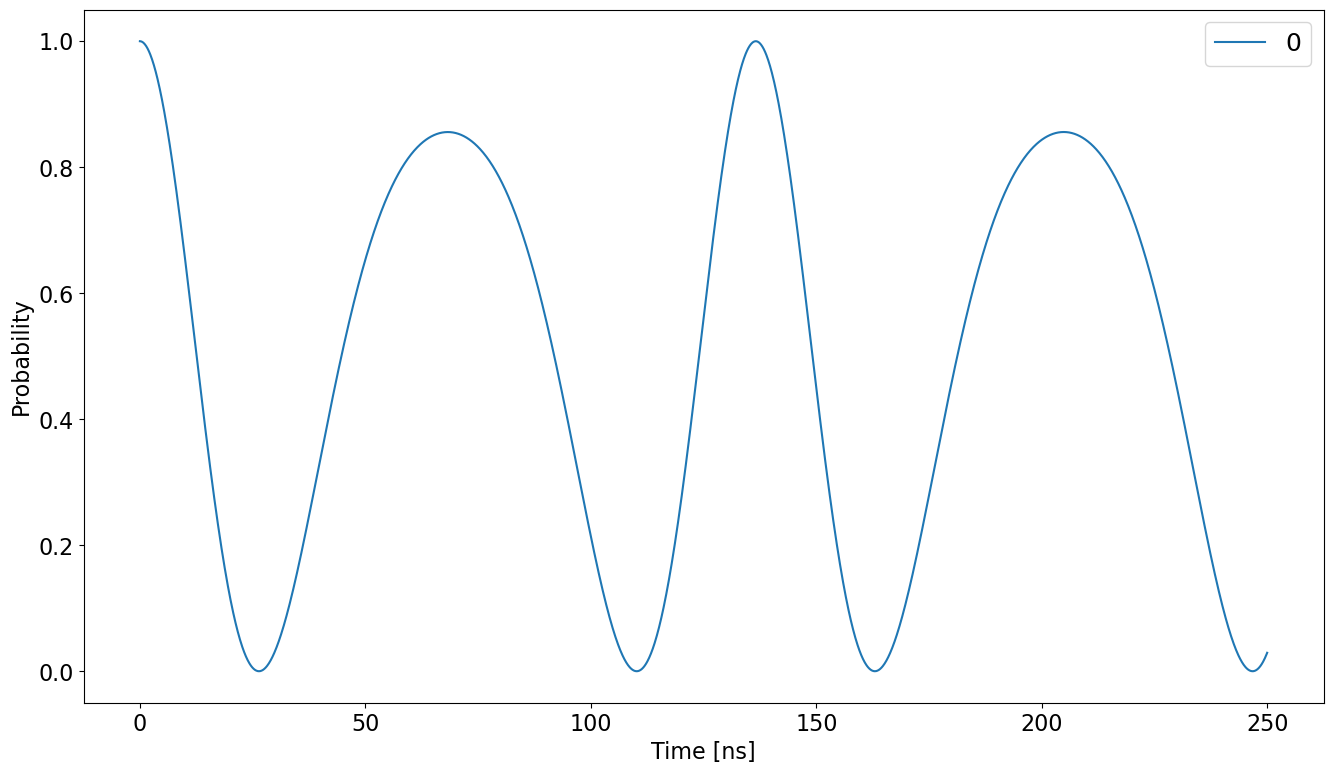

In [70]:
fig, ax = plt.subplots(figsize=(16,9))
# probs = np.abs(result.states) ** 2
probs = []
for state in result.states:
    probs.append((np.abs(state[0])**2)[0][0])
# ax.plot(result.times, probs[:,0], label="0")
# ax.plot(result.times, probs[:,1], label="1")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")
ax.plot(result.times, probs, label="0")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [43]:
(np.abs(result.states[0][0])**2)[0][0]

1.0

In [7]:
pop, pcov = curve_fit(sineSqFit, result.times, probs[:,1].flatten(), [1, 0.1, 0, 0 ])
print(pop)
print("Hello World")

[ 0.15773897  0.10158958 -0.71161677  0.41965077]
Hello World


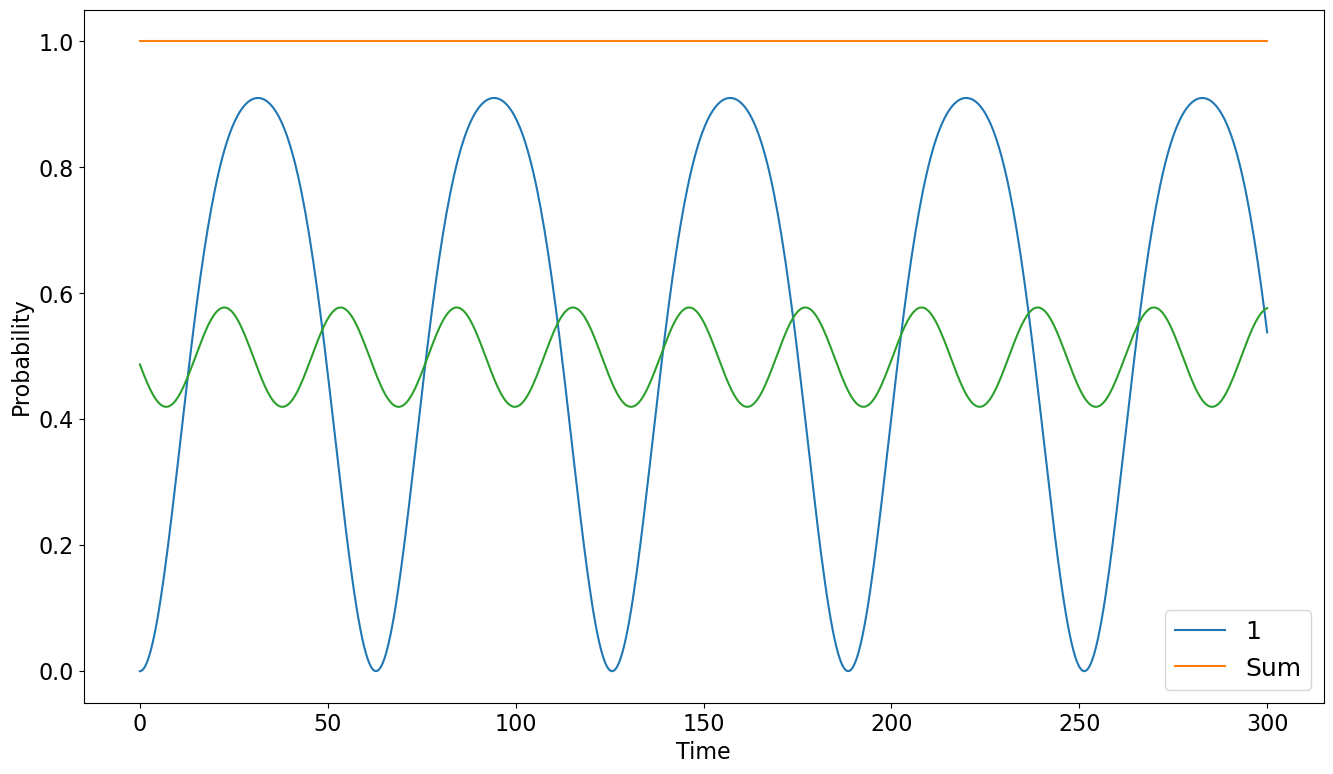

In [13]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1].flatten(), label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")
ax.plot(result.times, sineSqFit(result.times, *pop))
# ax.plot(result.times, sineSqFit(result.times, *[1, 0.1, 0, 0 ]))
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [20]:
print(pop)

In [66]:
def plot_setup(result):

    fig = plt.figure(figsize=(8, 8))
    axes = Axes3D(fig, azim=-40, elev=30)

    return fig, axes

In [75]:
sphere = None


def plot_result(result, n, fig=None, axes=None):

    global sphere

    if fig is None or axes is None:
        fig, axes = plot_setup(result)

    if not sphere:
        sphere = Bloch(axes=axes)
        sphere.vector_color = ["r"]

    sphere.clear()
    sphere.add_vectors([result.expect[0][n]])
                        # result.expect[1][n],
                        # result.expect[2][n]])
    sphere.add_points(
        [
            result.expect[0][: n + 1],
            # result.expect[1][: n + 1],
            # result.expect[2][: n + 1],
        ],
        meth="l",
    )
    sphere.make_sphere()

    return axes.artists

In [ ]:
plot_animation(plot_setup, plot_result, result, writer="ffmpeg", codec=None)

## Trying Bloch Sphere Visualization

In [14]:
b = Bloch()
b.add_states(result.states[0])
b.add_states(result.states[4])
print(b.fig)
print(b.axes)
b.render()

None
None


In [20]:
sphere = Bloch()
sphere.render()
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(result.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(result.times), init_func=init, blit=False, repeat=False)
writer = animation.PillowWriter(fps=30, bitrate=1800)
ani.save('bloch_sphere3.gif', writer=writer)

Axes3D(0,0;1x1) Figure(500x500)


In [ ]:
dir(b)

In [110]:
b.render()

# $T_1$ Simulation

In [43]:
H = Qobj([[-1,0],[0,1]])
g = 0.01
c_ops = [np.sqrt(g)*sigmam()]
psi0 = basis(2,0)
maxTime = 800
times = np.linspace(0,maxTime, 2*maxTime)
Mresults = mesolve(H, psi0, times, c_ops, progress_bar=True)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.04s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.05s


In [44]:
def expFit(t, A, d,DC):
    return A*np.exp(d*t)+DC

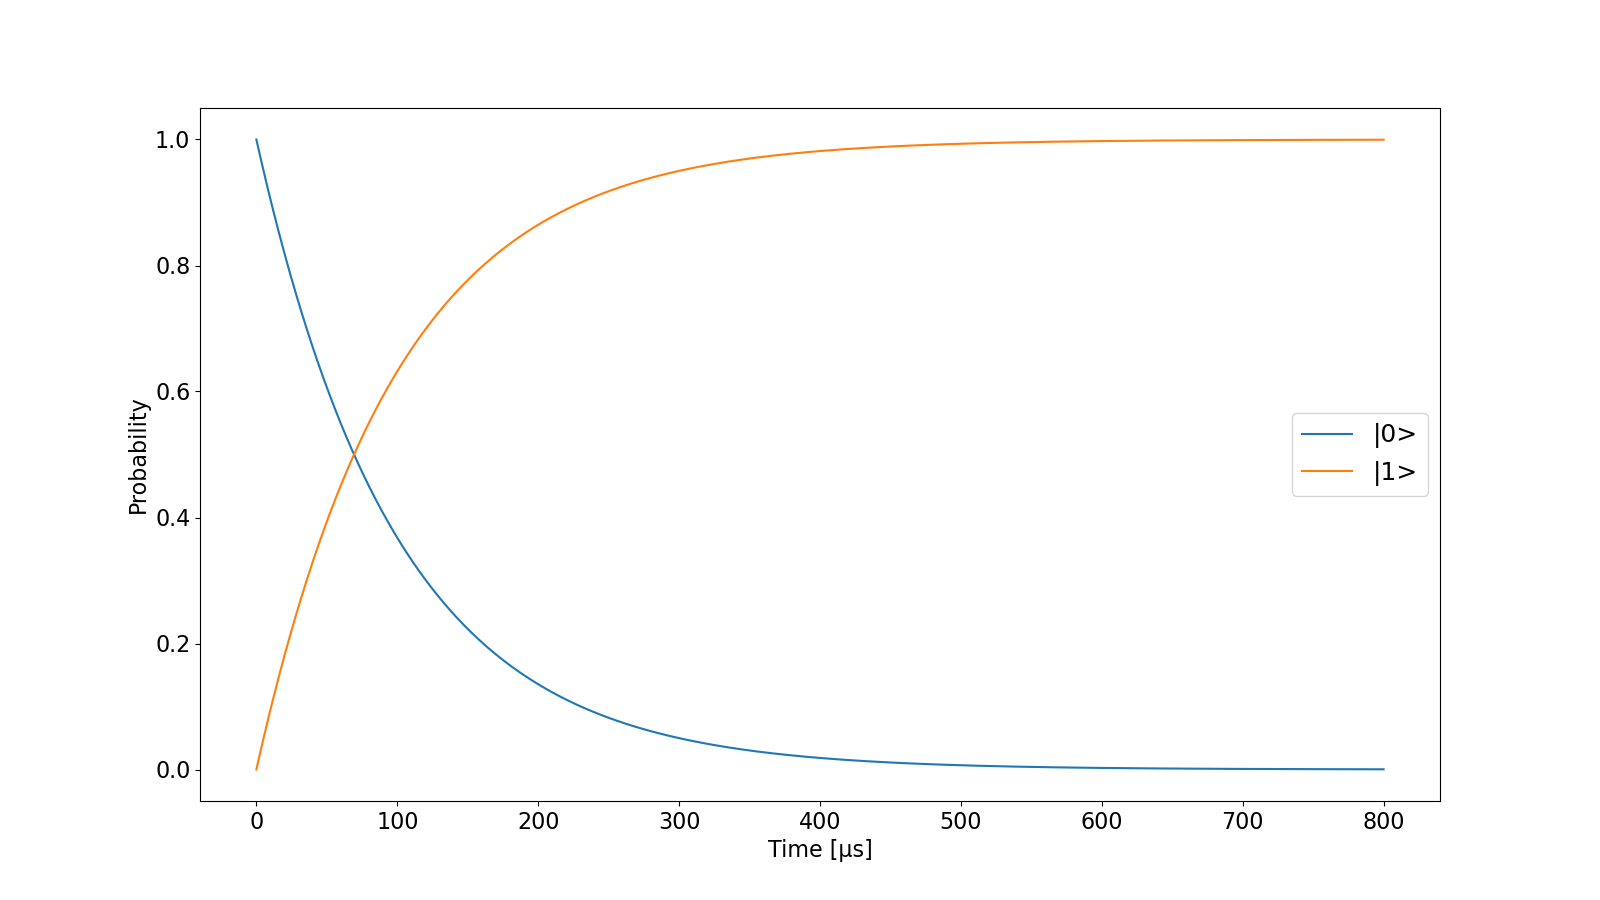

In [45]:

fig, ax = plt.subplots(figsize=(16,9))
# probs = np.abs(Mresults.states) ** 2
# m = Qobj([[0,0],[0,1]])*Mresults.states
# probs=[]
# for state in m:
#     probs.append(state[0,0]+state[1,1])
# ax.plot(result.times, probs[:,0], label="0")
states = np.array(Mresults.states)
ax.plot(Mresults.times, states[:,0,0], label="|0>")
ax.plot(Mresults.times, states[:,1,1], label="|1>")
pop, pcov = curve_fit(expFit, Mresults.times, states[:,1,1], [1,-0.01,0.25])
# ax.plot(Mresults.times, probs, label="1", linewidth=4)
# ax.plot(Mresults.times, expFit(Mresults.times, *pop), "--", label=f"{pop[0]:0.0f}exp({pop[1]:0.2f} t)+{pop[2]:0.1f}", linewidth=3)
# ax.plot(Mresults.times, expFit(Mresults.times, *[1,-0.01,0.25]), "--")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [μs]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [13]:
data = np.array(Mresults.states)

In [14]:
data[:,0,0]

array([1.00000000e+00+0.j, 9.95009368e-01+0.j, 9.90043642e-01+0.j, ...,
       3.38847747e-04+0.j, 3.37156700e-04+0.j, 3.35474095e-04+0.j])

Axes3D(0,0;1x1) Figure(500x500)


IndexError: list index out of range

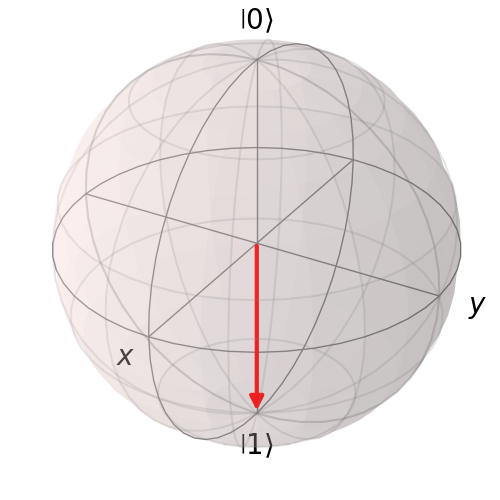

In [33]:
sphere = Bloch();
sphere.render();
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(Mresults.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(Mresults.times), init_func=init, blit=False, repeat=False);
writer = animation.PillowWriter(fps=30, bitrate=1800);
ani.save('T1_BlochSphere.gif', writer=writer);

## $T_2$ Dephasing Time

In [240]:
H = Qobj([[0,0],[0,1]])
g = 0.1
c_ops = [np.sqrt(g)*sigmax()]
psi0 = HD()*basis(2,0)
maxTime = 100
times = np.linspace(0,maxTime, 4*maxTime)
Mresults = mesolve(H, psi0, times, c_ops, progress_bar=True)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


In [241]:
Mresults

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 1

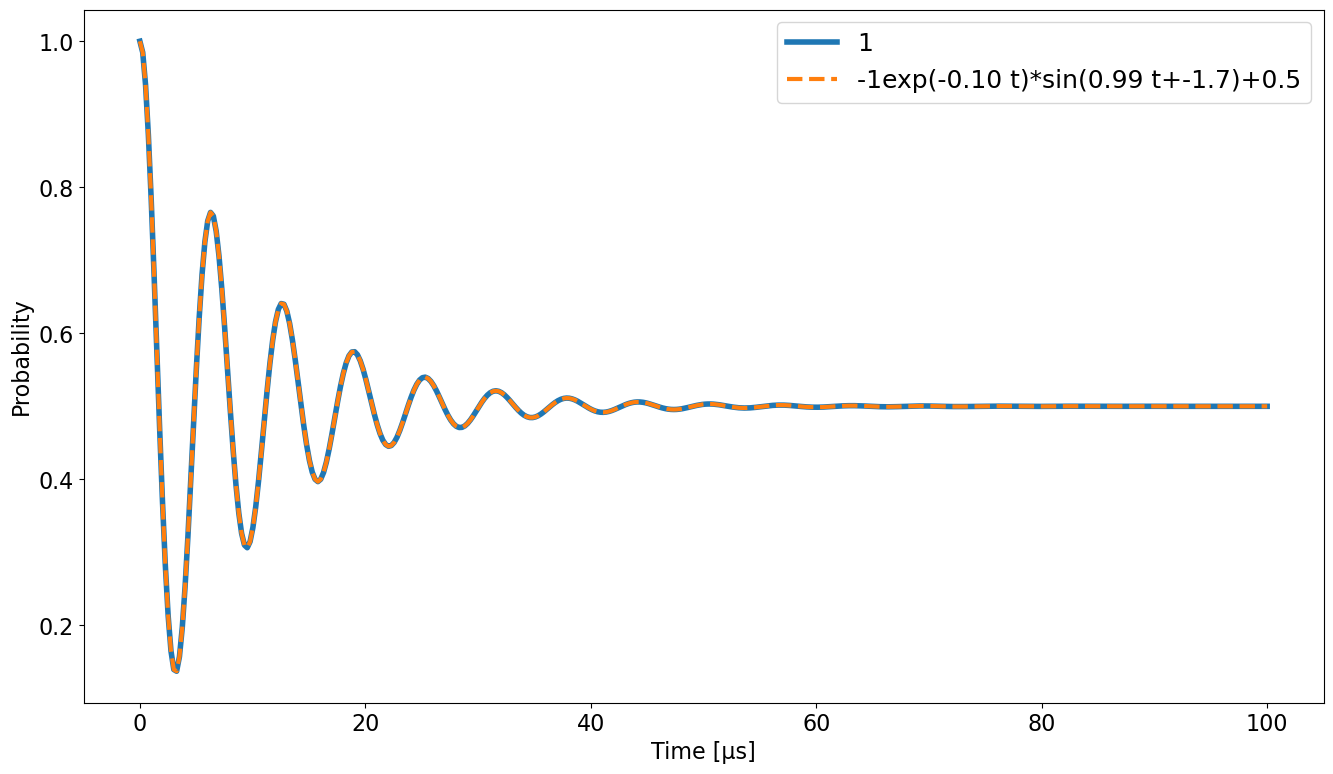

In [301]:
fig, ax = plt.subplots(figsize=(16,9))
# probs = np.abs(Mresults.states) ** 2
tempStates = []
RY = ry(np.pi/2)
for state in Mresults.states:
    tempStates.append(RY*state*RY.dag())
m = Qobj([[0,0],[0,1]])*tempStates
probs=[]
for state in m:
    probs.append((state[0,0]+state[1,1]))
# ax.plot(result.times, probs[:,0], label="0")
pop, pcov = curve_fit(dampedSineFit, Mresults.times, probs, [0.5,-0.1,10/20, 0, 0.5])
ax.plot(Mresults.times, probs, label="1", linewidth=4)
ax.plot(Mresults.times, dampedSineFit(Mresults.times, *pop), "--", label=f"{pop[0]:0.0f}exp({pop[1]:0.2f} t)*sin({pop[2]:0.2f} t+{pop[3]:0.1f})+{pop[4]:0.1f}", linewidth=3)
# ax.plot(Mresults.times, expFit(Mresults.times, *[1,-0.01,0.25]), "--")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time [μs]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [295]:
print(pop)

[-0.27387286 -0.03546636  0.50257809 -0.13095287  0.53864819]


In [243]:
sphere = Bloch()
sphere.render()
print(sphere.axes, sphere.fig)

def animate(i):
    sphere.clear()
    sphere.add_states(Mresults.states[i])
    sphere.render()
    return sphere.axes

def init():
    sphere.vector_color = ["r"]
    return sphere.axes

# sphere.clear()
# sphere.add_states(result.states[0])
# sphere.render()
ani = animation.FuncAnimation(sphere.fig, animate, len(Mresults.times), init_func=init, blit=False, repeat=False)
writer = animation.PillowWriter(fps=30, bitrate=1800)
ani.save('T1_BlochSphere.gif', writer=writer)

Axes3D(0,0;1x1) Figure(500x500)


# Recreating Hurst Plots part 2

In [46]:
δν = 0.025
νp = 5.0
Ωx = 0.0633
ϵ = 5.0
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2
ψ0 = basis(2, 0)
times = np.linspace(0, 250, 2500)
result = sesolve(H2, ψ0, times, e_ops=[], args=dict(eps=ϵ, vp=νp, omegaX=Ωx, dv=δν), progress_bar=True)

10.0%. Run time:   1.25s. Est. time left: 00:00:00:11
20.0%. Run time:   2.25s. Est. time left: 00:00:00:08
30.0%. Run time:   3.11s. Est. time left: 00:00:00:07
40.0%. Run time:   4.10s. Est. time left: 00:00:00:06
50.0%. Run time:   5.35s. Est. time left: 00:00:00:05
60.0%. Run time:   6.39s. Est. time left: 00:00:00:04
70.0%. Run time:   7.37s. Est. time left: 00:00:00:03
80.0%. Run time:   8.25s. Est. time left: 00:00:00:02
90.0%. Run time:   9.22s. Est. time left: 00:00:00:01
Total run time:  10.31s


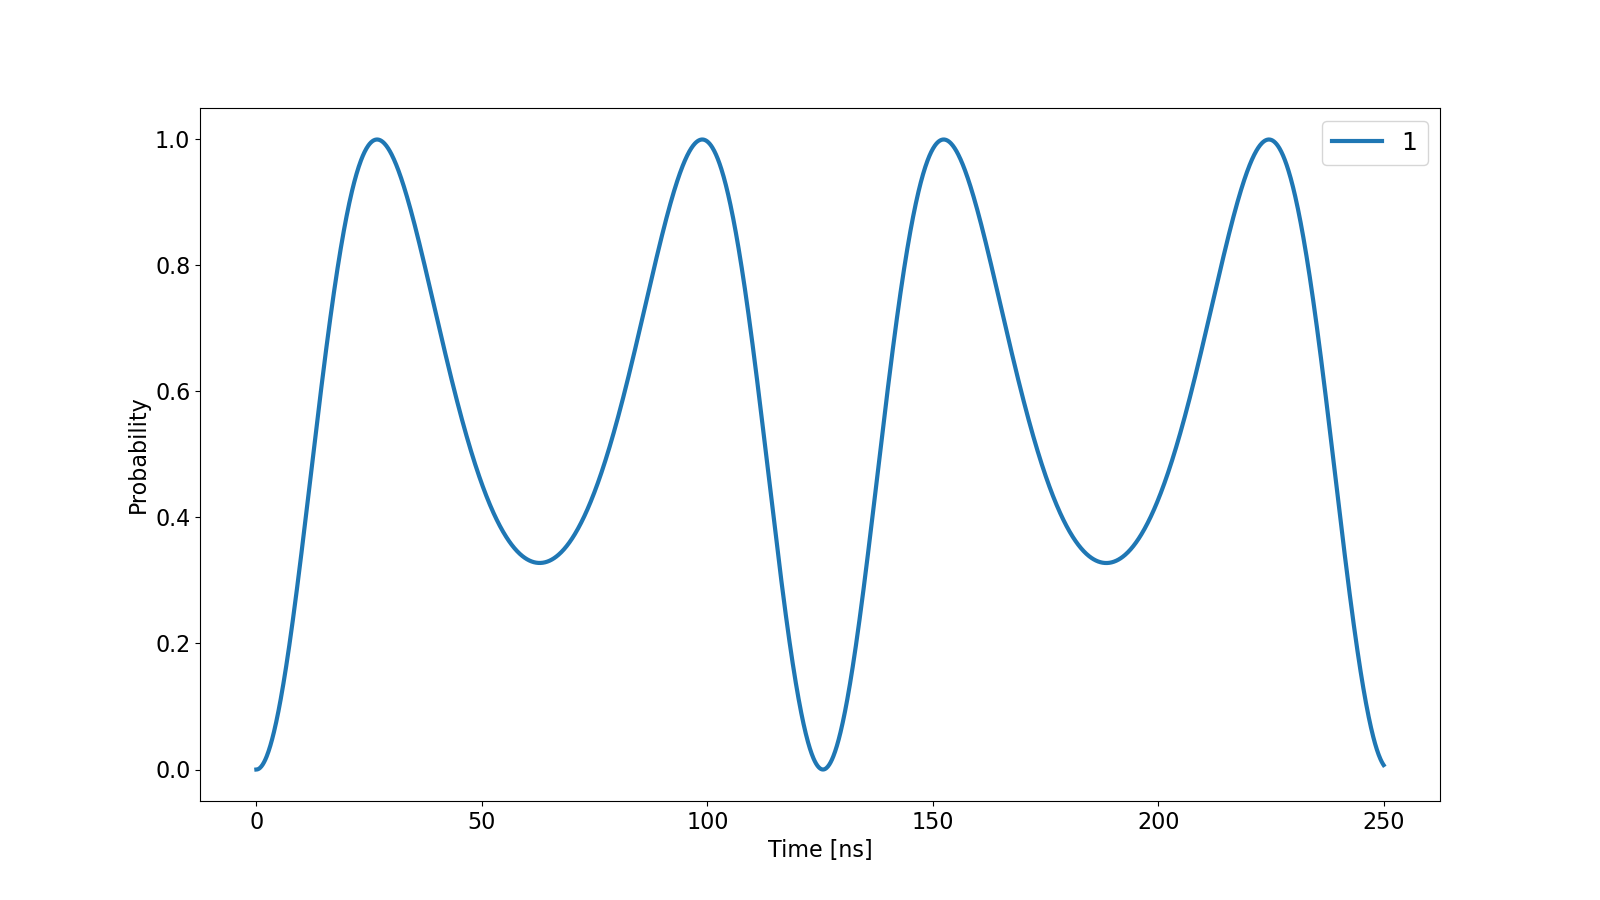

In [60]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# probs = []
# for state in result.states:
#     probs.append((np.abs(state[0])**2)[0][0])
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1,0], label="1")
# ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")
# ax.plot(result.times, probs, label="0")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [65]:
δvmin = 0.010
δvmax = 0.040
nδv = 25
νp = 5.0
Ωx = 0.0633
ϵ = 5.0
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2
ψ0 = basis(2, 0)
times = np.linspace(0, 250, 2500)
results = []
δvs = np.linspace(δvmin,δvmax, nδv)
for δv in δvs:
    result = sesolve(H2, ψ0, times, e_ops=[], args=dict(eps=ϵ, vp=νp, omegaX=Ωx, dv=δv), progress_bar=True)
    results.append(result)

10.0%. Run time:   1.18s. Est. time left: 00:00:00:10
20.0%. Run time:   2.22s. Est. time left: 00:00:00:08
30.0%. Run time:   3.24s. Est. time left: 00:00:00:07
40.0%. Run time:   4.20s. Est. time left: 00:00:00:06
50.0%. Run time:   5.05s. Est. time left: 00:00:00:05
60.0%. Run time:   6.01s. Est. time left: 00:00:00:04
70.0%. Run time:   6.97s. Est. time left: 00:00:00:02
80.0%. Run time:   7.89s. Est. time left: 00:00:00:01
90.0%. Run time:   8.83s. Est. time left: 00:00:00:00
Total run time:   9.83s
10.0%. Run time:   1.02s. Est. time left: 00:00:00:09
20.0%. Run time:   2.05s. Est. time left: 00:00:00:08
30.0%. Run time:   3.06s. Est. time left: 00:00:00:07
40.0%. Run time:   4.03s. Est. time left: 00:00:00:06
50.0%. Run time:   4.91s. Est. time left: 00:00:00:04
60.0%. Run time:   5.78s. Est. time left: 00:00:00:03
70.0%. Run time:   6.65s. Est. time left: 00:00:00:02
80.0%. Run time:   7.62s. Est. time left: 00:00:00:01
90.0%. Run time:   8.59s. Est. time left: 00:00:00:00
Tota

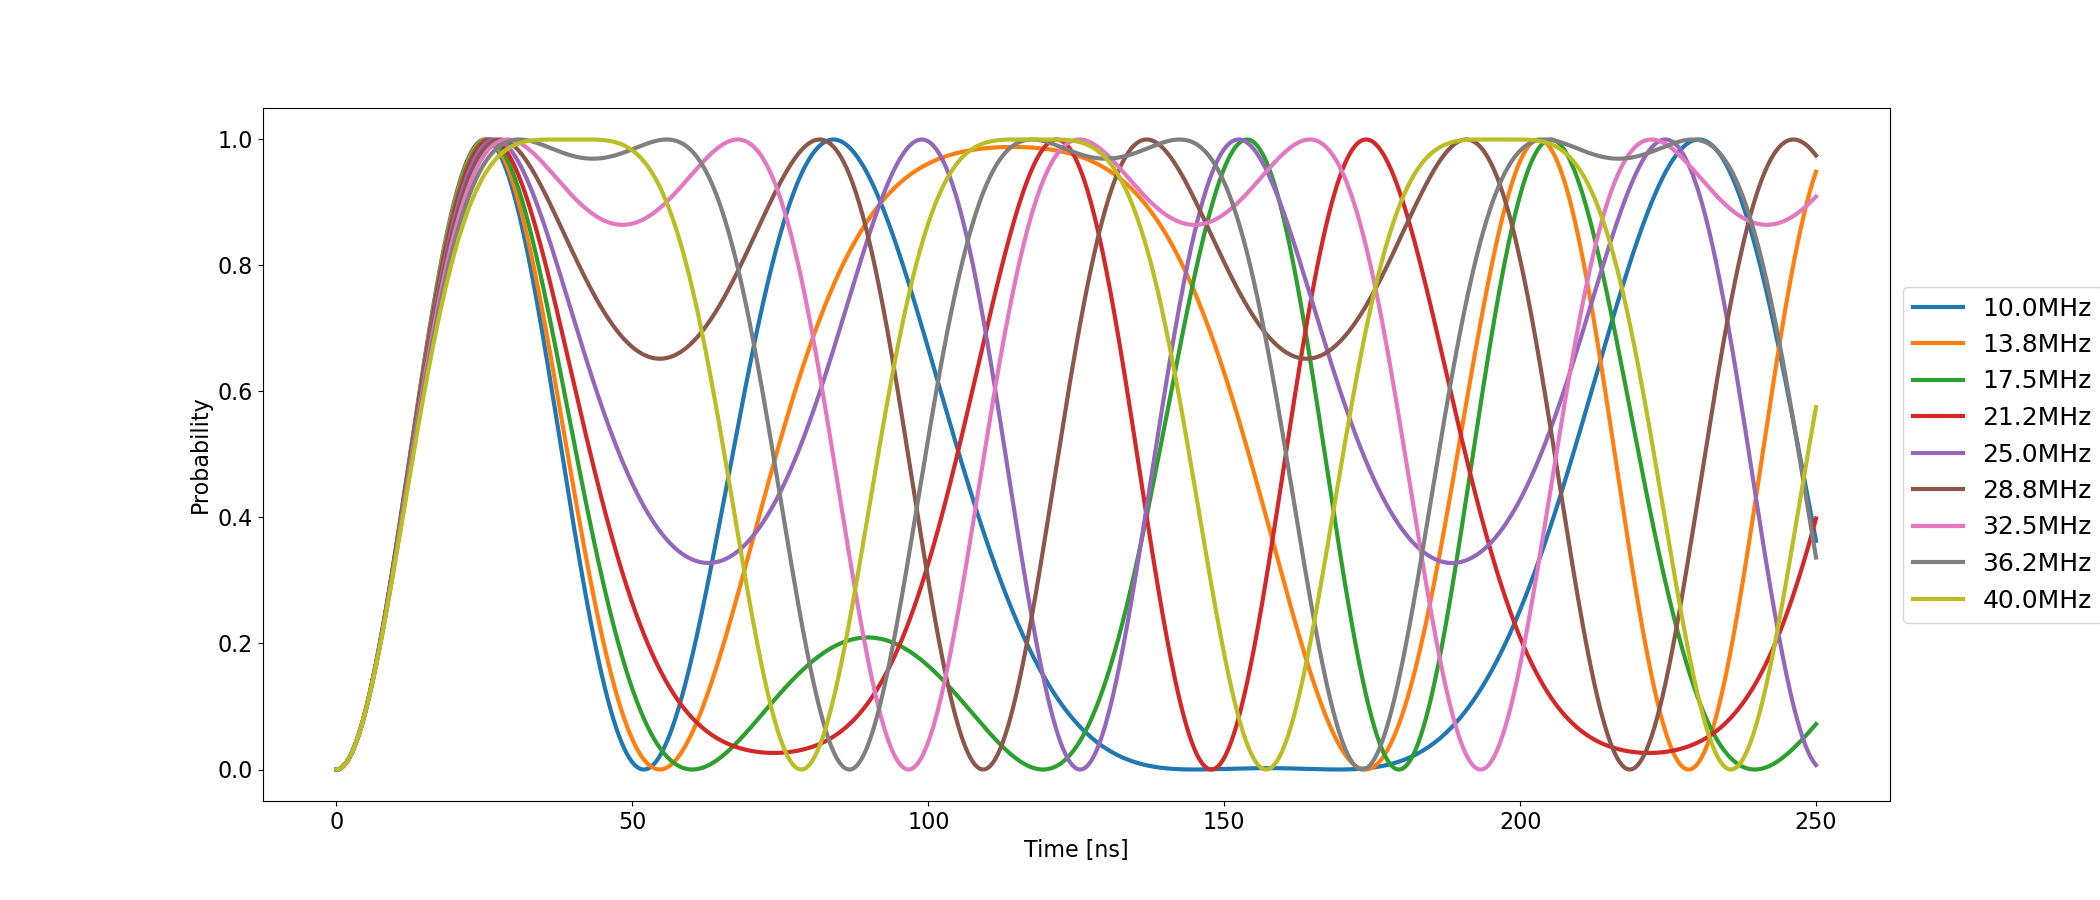

In [71]:
fig, ax = plt.subplots(figsize=(21,9))
spacing = 3
for i, result in enumerate(results):
    if i%spacing==0:
        probs = np.abs(result.states) ** 2
        ax.plot(result.times, probs[:,1,0], label=f"{round(δvs[i],4)*1000:0.1f}MHz")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Two-Field Simulation with Master Equation

In [4]:
def FM(t, A, v1, p1, v2, p2, DC, d):
    return A *np.exp(d*t)*np.cos(p1+v1*np.sin(v2*t+p2))+DC

def dampedSineFit(t, A, d, v, ϕ, DC):
    return A*np.exp((d*t))*np.sin(v*t+ ϕ) + DC

def sineSqFit(t,A,v,ϕ, DC):
    return A*(np.sin(v*t+ϕ))**2+DC

def FM2(t, A, v1, p1, v2, p2, DC, d):
    return A *np.exp(d*t)*np.cos(p1+v1*np.sin(v2*t+p2)*t)+DC

def FM3(t, A, v1, p1, v2, p2, B, DC, d):
    return A *np.exp(d*t)*np.cos(p1+v1*t+B*np.sin(v2*t+p2))+DC

def FM_Simple(t, A, d, v1, v2, DC):
    return A *np.exp(d*t)*np.cos(v1*np.sin(v2*t))+DC

In [5]:
dv = 0.016
vp = 5.0
Ωx = 0.0633
ϵ = 5.0
tmax = 15000
nt = 5
ψ0 = basis(2, 0)
c_ops = [np.sqrt(0.00001)*sigmam(), np.sqrt(0.0001)*sigmaz()]
times = np.linspace(0, tmax, nt*tmax)

result = mesolve(H2, ψ0, times, c_ops=c_ops, e_ops=[], args=dict(eps=ϵ, vp=vp, omegaX=Ωx, dv=dv), progress_bar=True)
states = np.array(result.states)
zero = states[:,0,0]

10.0%. Run time:   2.72s. Est. time left: 00:00:00:24
20.0%. Run time:   4.94s. Est. time left: 00:00:00:19
30.0%. Run time:   6.95s. Est. time left: 00:00:00:16
40.0%. Run time:   9.04s. Est. time left: 00:00:00:13
50.0%. Run time:  10.99s. Est. time left: 00:00:00:10
60.0%. Run time:  12.75s. Est. time left: 00:00:00:08
70.0%. Run time:  14.33s. Est. time left: 00:00:00:06
80.0%. Run time:  15.60s. Est. time left: 00:00:00:03
90.0%. Run time:  16.94s. Est. time left: 00:00:00:01
Total run time:  18.28s


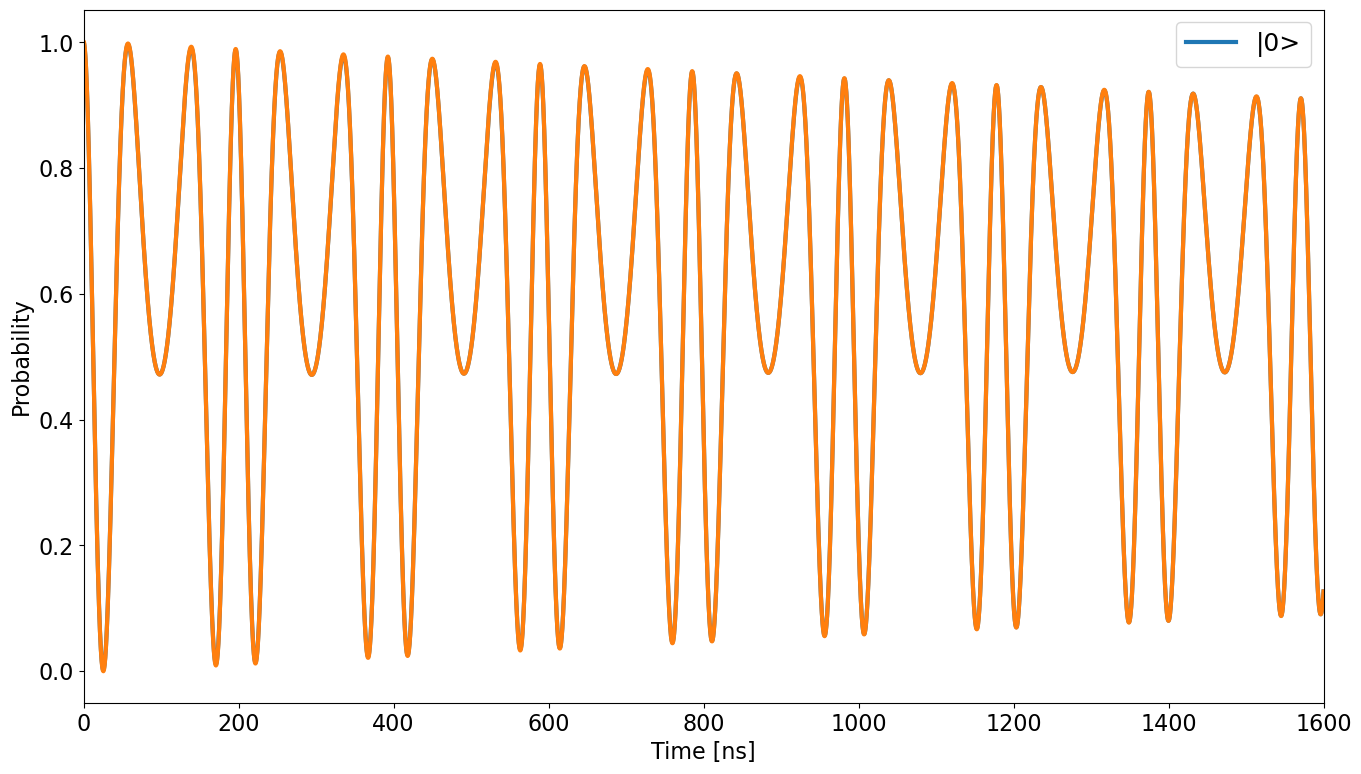

In [69]:
lim = 1600
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(result.times, zero, label="|0>")
f1 = (1+4*Ωx)/(10*dv)
f2 = dv
pop, pcov = curve_fit(FM3, result.times, zero, [0.5, 0, 0, 0.015, 0, 8, 0.5, -0.000175])
# pop1, pcov1 = curve_fit(FM, result.times, zero, [0.5, f1, 0, f2, 0, 0.5, 0.000175])
# ax.plot(result.times, FM3(result.times, *[0.5, 0.01, 0, 0.01, 0, 0.05, 0.5, -0.000175]))
ax.plot(result.times, FM3(result.times, *pop))
# ax.plot(result.times, FM(result.times, *pop1))
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
ax.set_xlim(0,lim)
ax.legend()
plt.show()

In [61]:
print(pop)

[ 4.98359318e-01  6.40017992e-02  4.75760215e-01  3.19993244e-02
 -3.47343779e-01  2.51708942e+00  5.05318502e-01 -1.26869816e-04]


In [8]:
dvmin = 0.1
dvmax = 5
ndv = 100
dvs = np.linspace(dvmin, dvmax, ndv)
vp = 5.0
Ωx = 0.0633
ϵ = 5.0
tmax = 5000
nt = 5
d = -0.0001
ψ0 = basis(2, 0)
c_ops = [np.sqrt(0.00001)*sigmam(), np.sqrt(0.0001)*sigmaz()]
times = np.linspace(0, tmax, nt*tmax)
v1s = []
v2s = []
dvdata = []
ds = []
for dv in dvs:
    print(f"RUNNING: dv={dv:6f}GHz")
    result = mesolve(H2, ψ0, times, c_ops=c_ops, e_ops=[], args=dict(eps=ϵ, vp=vp, omegaX=Ωx, dv=dv))
    states = np.array(result.states)
    zero = states[:,0,0]
    f1 = (1+4*Ωx)/(10*dv)
    f2 = dv
    try:
        pop, pcov = curve_fit(FM_Simple, result.times, zero, [0.5, d, f1, f2, 0.5])
    except RuntimeError:
        print(f"\t{dv:6f}GHz FAILED!")
        continue
    v1s.append(pop[2])
    v2s.append(pop[3])
    ds.append(pop[1])
    dvdata.append(dv)
print("Run complete!")

RUNNING: dv=0.100000GHz
RUNNING: dv=0.149495GHz
RUNNING: dv=0.198990GHz
RUNNING: dv=0.248485GHz
RUNNING: dv=0.297980GHz
RUNNING: dv=0.347475GHz
RUNNING: dv=0.396970GHz
RUNNING: dv=0.446465GHz
RUNNING: dv=0.495960GHz
RUNNING: dv=0.545455GHz
RUNNING: dv=0.594949GHz
RUNNING: dv=0.644444GHz
RUNNING: dv=0.693939GHz
RUNNING: dv=0.743434GHz
RUNNING: dv=0.792929GHz
RUNNING: dv=0.842424GHz
RUNNING: dv=0.891919GHz
RUNNING: dv=0.941414GHz
RUNNING: dv=0.990909GHz
RUNNING: dv=1.040404GHz
RUNNING: dv=1.089899GHz
RUNNING: dv=1.139394GHz
RUNNING: dv=1.188889GHz
RUNNING: dv=1.238384GHz
RUNNING: dv=1.287879GHz
RUNNING: dv=1.337374GHz
RUNNING: dv=1.386869GHz
RUNNING: dv=1.436364GHz
RUNNING: dv=1.485859GHz
RUNNING: dv=1.535354GHz
RUNNING: dv=1.584848GHz
RUNNING: dv=1.634343GHz
RUNNING: dv=1.683838GHz
RUNNING: dv=1.733333GHz
RUNNING: dv=1.782828GHz
RUNNING: dv=1.832323GHz
RUNNING: dv=1.881818GHz
RUNNING: dv=1.931313GHz
RUNNING: dv=1.980808GHz
RUNNING: dv=2.030303GHz
RUNNING: dv=2.079798GHz
RUNNING: dv=2.12

In [83]:
def v1Fit(dv, A):
    return A/dv

def v1Guess(dv, Ωx):
    return (1+4*Ωx)/(10*dv)

def line(x, m, b):
    return m*x+b


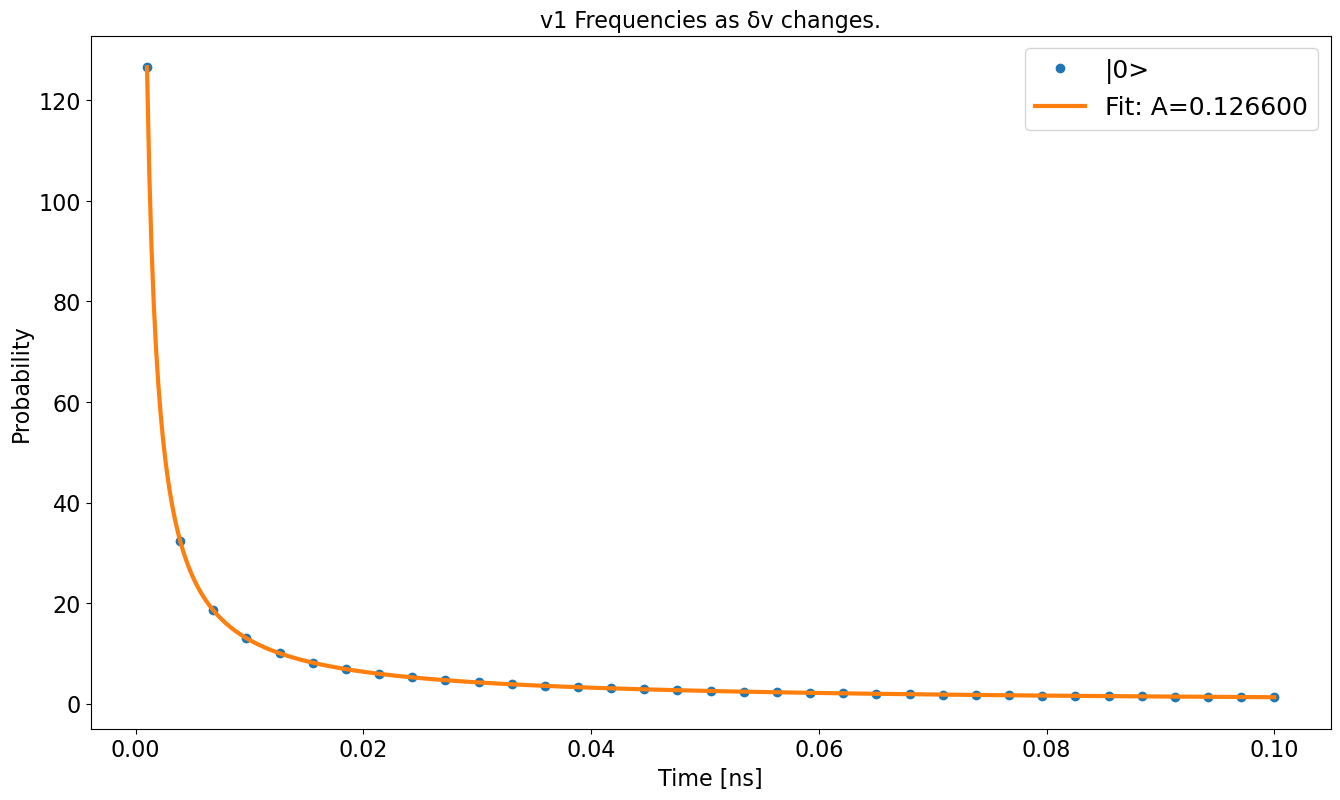

In [77]:
# lim = 1600
fig, ax = plt.subplots(figsize=(16,9))
fakedvs = np.linspace(dvmin, dvmax, 500)
ax.plot(dvdata, v1s, "o", label="|0>")
title = "v1 Frequencies as δv changes."
f1 = (1+4*Ωx)/(10*dv)
f2 = dv
pop, pcov = curve_fit(v1Fit, dvdata, v1s, [(1+4*Ωx)/(10)])
# pop1, pcov1 = curve_fit(FM, result.times, zero, [0.5, f1, 0, f2, 0, 0.5, 0.000175])
# ax.plot(result.times, FM3(result.times, *[0.5, 0.01, 0, 0.01, 0, 0.05, 0.5, -0.000175]))
ax.plot(fakedvs, v1Fit(fakedvs, *pop), label=f"Fit: A={pop[0]:0.6f}")
# ax.plot(fakedvs, v1Guess(fakedvs, Ωx), "--", label="Guess")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
# ax.set_xlim(0,lim)
ax.set_title(title)
ax.legend()
plt.show()

In [79]:
A = (1+4*Ωx)/10

In [80]:
(A-0.12600)/((A+0.12600)/2)

-0.005411427661944821

LinregressResult(slope=0.9999997282919145, intercept=4.706576878232838e-09, rvalue=0.9999999999999877, pvalue=4.013212625902287e-226, stderr=2.7329048677368415e-08, intercept_stderr=1.5970652990562402e-09)


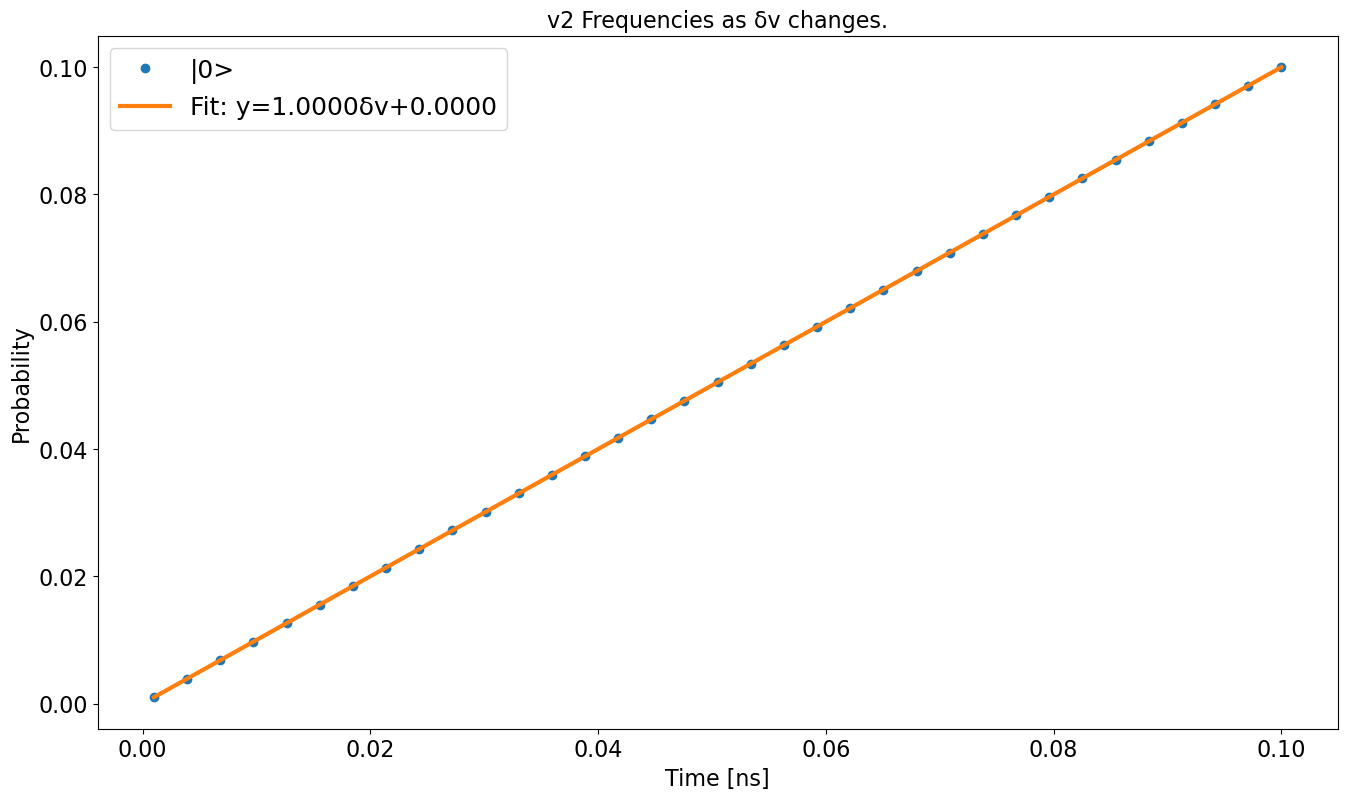

In [87]:
fig, ax = plt.subplots(figsize=(16,9))
fakedvs = np.linspace(dvmin, dvmax, 500)
ax.plot(dvdata, v2s, "o", label="|0>")
title = "v2 Frequencies as δv changes."
f1 = (1+4*Ωx)/(10*dv)
f2 = dv
fitData = linregress(dvdata, v2s)
print(fitData)
# pop1, pcov1 = curve_fit(FM, result.times, zero, [0.5, f1, 0, f2, 0, 0.5, 0.000175])
# ax.plot(result.times, FM3(result.times, *[0.5, 0.01, 0, 0.01, 0, 0.05, 0.5, -0.000175]))
ax.plot(fakedvs, line(fakedvs, fitData.slope, fitData.intercept), label=f"Fit: y={fitData.slope:0.4f}δv+{fitData.intercept:0.4f}")
# ax.plot(fakedvs, v1Guess(fakedvs, Ωx), "--", label="Guess")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Probability")
# ax.set_xlim(0,lim)
ax.set_title(title)
ax.legend()
plt.show()

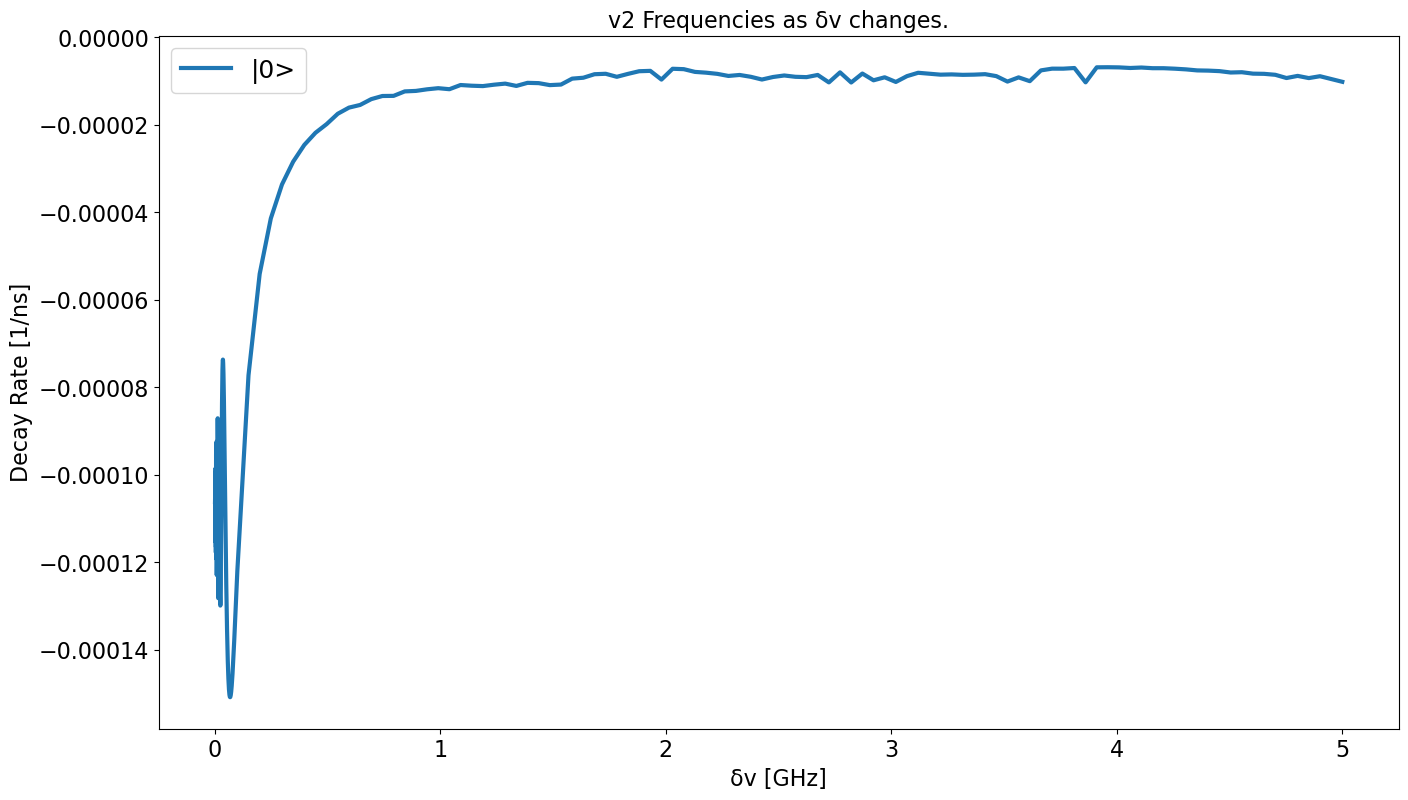

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
fakedvs = np.linspace(dvmin, dvmax, 500)
dconcat = ds_original + ds[:]
dvconcat = dvs_original + dvdata[:]
ax.plot(dvconcat, dconcat, label="|0>")
title = "v2 Frequencies as δv changes."

f1 = (1+4*Ωx)/(10*dv)
f2 = dv
# fitData = linregress(dvdata, v2s)
# print(fitData)
# pop1, pcov1 = curve_fit(FM, result.times, zero, [0.5, f1, 0, f2, 0, 0.5, 0.000175])
# ax.plot(result.times, FM3(result.times, *[0.5, 0.01, 0, 0.01, 0, 0.05, 0.5, -0.000175]))
# ax.plot(fakedvs, line(fakedvs, fitData.slope, fitData.intercept), label=f"Fit: y={fitData.slope:0.4f}δv+{fitData.intercept:0.4f}")
# ax.plot(fakedvs, v1Guess(fakedvs, Ωx), "--", label="Guess")
ax.set_xlabel("δv [GHz]")
ax.set_ylabel("Decay Rate [1/ns]")
# ax.set_xlim(0,lim)
ax.set_title(title)
ax.legend()
plt.show()

In [7]:
ds_original = ds[:]
dvs_original = dvdata[:]

In [95]:
ds_original

[-0.00010624873244642934,
 -0.00010503315771172925,
 -0.00010622606468290852,
 -9.492465265356374e-05,
 -8.83106173626332e-05,
 -0.00012819468978378574,
 -9.144768410431525e-05,
 -0.0001080527894330547,
 -0.00012964874052651012,
 -0.00011925250322012623,
 -9.621669204647853e-05,
 -7.916628628880184e-05,
 -7.367995791001486e-05,
 -7.785549977921662e-05,
 -8.786426272197834e-05,
 -0.00010021896618977528,
 -0.00011261873754929121,
 -0.0001237392829444107,
 -0.00013291939509384534,
 -0.00014005690269776918,
 -0.00014519602782257464,
 -0.0001485254395933079,
 -0.00015034197507804672,
 -0.00015086689469413322,
 -0.00015036357784816717,
 -0.00014902894468944074,
 -0.00014706310157133493,
 -0.00014460919854927004,
 -0.00014181214334069785,
 -0.00013872837847568804,
 -0.00013549394865778965,
 -0.00013216091734735805,
 -0.0001287456410081578,
 -0.0001253577852015438,
 -0.00012197979935975355]

In [99]:
(0.001-0.04)/50

-0.00078

In [101]:
(0.1-0.001)/500

0.00019800000000000002

In [16]:
np.savetxt("ds.txt", dconcat)